In [1]:
import pandas as pd
import numpy as np

# Fundamental data preprocessing


In [2]:
# CSV of publically traded healthcare companies as classified by GIC subindustry codes
df = pd.read_csv('healthcare_fundamentals_v3.csv') #update w/ latest version

key_table = df[['cik', 'GVKEY']] #keys to join all databases
key_table.head()

C:\Users\Derrick\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (23,33,37,955,956,957,962,976,977) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cik,GVKEY
0,319126.0,1021
1,319126.0,1021
2,319126.0,1021
3,319126.0,1021
4,319126.0,1021


In [3]:
#all companies in healthcare industry from 2000 - 2010
print('Total number of unique companies from 2000 - 2010:',df['GVKEY'].nunique())

Total number of unique companies from 2000 - 2010: 1975


In [4]:
#eliminate private companies (ipodate = nan)
mask = df['ipodate'].isna()
print(mask.sum())
print(df.shape)
print(df[-mask].shape)
df = df[-mask]

5251
(14065, 988)
(8814, 988)


In [5]:
#number of public healthcare companies
print('Total number of unique public companies from 2000 - 2010:',df['GVKEY'].nunique())

Total number of unique public companies from 2000 - 2010: 1175


In [6]:
#eliminate rows with no market cap information
mask = df['mkvalt'].isna()
df = df[-mask]
print('Total number of unique public companies with market cap from 2000 - 2010:',df['GVKEY'].nunique())

Total number of unique public companies with market cap from 2000 - 2010: 1055


In [7]:
# df['year'] =  pd.to_datetime(df['datadate']).dt.year
# mask = df['year'] == 2000

# df[mask]['GVKEY'].value_counts()

In [8]:
df['year'] =  pd.to_datetime(df['datadate']).dt.year
df = df.drop_duplicates(['year','GVKEY'])

In [9]:
print('Total number of unique private companies with market cap from 2000 - 2010:',df['GVKEY'].nunique())

Total number of unique private companies with market cap from 2000 - 2010: 1055


# Read in Bankruptcy Data and Merge with Fundamentals

In [10]:
# Bankrupt healthcare companies
df_bankrupt = pd.read_csv('healthcare_bankrupt_audit_analytics_v2.csv')

In [11]:
print('Total of:' ,len(df_bankrupt), "bankruptcy filings")

Total of: 187 bankruptcy filings


In [12]:
#create year column
df_bankrupt['bankrupt_year'] = pd.to_datetime(df_bankrupt['BANK_BEGIN_DATE']).dt.year

#filter for year 2001- 2010
mask = (df_bankrupt['bankrupt_year'] >2000) &  (df_bankrupt['bankrupt_year']  < 2011)
df_bankrupt = df_bankrupt[mask]


In [13]:
print('Total of:' ,len(df_bankrupt), "bankruptcy filings between 2001 and 2010")

Total of: 129 bankruptcy filings between 2001 and 2010


In [14]:
# Get chapter 11 companies only
df_bankrupt= df_bankrupt[df_bankrupt['BANKRUPTCY_TYPE']==11]
print('Total of:' ,len(df_bankrupt), "CH 11 bankruptcy filings between 2001 and 2010")

Total of: 82 CH 11 bankruptcy filings between 2001 and 2010


In [15]:
df_bankrupt['bankrupt_year'].value_counts().sort_index().plot(kind = 'bar', title = 'Number of CH11 Bankruptcies by Year')

# Merge Financial Ratios

In [16]:
#create cik - GVKEY table from fundamentals dataset
key_table = key_table.drop_duplicates()
key_table.head()

,cik,GVKEY
0,319126.0,1021
9,730469.0,1034
17,1800.0,1078
28,2034.0,1094
39,313798.0,1115


In [17]:
df_fin_ratio = pd.read_csv('fin ratios.csv')
df_fin_ratio['gvkey'].nunique()

1244

In [18]:
bankrupt_key  = pd.merge(df_bankrupt, key_table, left_on = 'COMPANY_FKEY', right_on = 'cik', suffixes = ('_ratio', '_key'), how = 'inner')
# df_table = df_table.drop_duplicates()

In [19]:
bankrupt_key.shape

(82, 467)

In [20]:
df_fin_ratio=df_fin_ratio.drop_duplicates(subset=['gvkey','qdate'], keep='last')
df_fin_ratio['qmonth']=pd.to_datetime(df_fin_ratio['qdate']).dt.month
mask= df_fin_ratio['qmonth']==12
df_fin_ratio= df_fin_ratio[mask]

df_fin_ratio.shape

(7526, 76)

In [21]:
fin_ratio_bankruptcy = pd.merge(df_fin_ratio, bankrupt_key, left_on = 'gvkey', right_on = 'GVKEY', suffixes = ('_finratio', '_bankrupt'), how = 'left')
#processing for fin ratio to drop duplicates
fin_ratio_bankruptcy['year'] = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year

In [22]:
fin_ratio_bankruptcy.shape

(7526, 544)

In [23]:
#create bankruptcy dummy
#adate is year end date
mask = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year + 1 == pd.to_datetime(fin_ratio_bankruptcy['BANK_BEGIN_DATE']).dt.year

fin_ratio_bankruptcy['bankrupted'] = np.where(mask, 1,0)

In [24]:
fin_ratio_bankruptcy['gvkey'].nunique()

1154

In [25]:
fin_ratio_bankruptcy['year'] = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year

In [26]:
fund_ratio_bank  = pd.merge(df, fin_ratio_bankruptcy, left_on = ['GVKEY', 'year'], right_on = ['gvkey', 'year'], suffixes = ('_fund', '_ratio'), how = 'inner')
fund_ratio_bank = fund_ratio_bank.drop(columns = 'GVKEY_ratio')
fund_ratio_bank = fund_ratio_bank.rename(columns = {'GVKEY_fund' : 'GVKEY'})


In [27]:
print('The final dataset includes:',fund_ratio_bank['GVKEY'].nunique(), 'companies, which have fundamental as well as financial ratios values')

The final dataset includes: 817 companies, which have fundamental as well as financial ratios values


In [28]:
fund_ratio_bank.head()

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupt_year,cik_ratio,bankrupted
0,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2000,2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2001,2001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1177,J,03,NR,NaN,NaN,06/29/2001,01/31/2006,12/31/2002,2002.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2003,2003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2004,2004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [29]:
#filter for market cap size (in MM)
#recommend using this after creating bankruptcy dummy

def market_cap_size(df, lower, upper):
    
    mask = ((df['mkvalt'] >=lower) & (df['mkvalt'] <=upper))
    df =df[mask]
    
    return df


#market cap 500M - 1B
df500 = market_cap_size(fund_ratio_bank, 0,1000)

df500['GVKEY'].nunique()

747

In [30]:
df500['bankrupted'].sum()

24

In [31]:
# get list of financial ratio that could be used as input
listratio=[]
for col in df_fin_ratio.columns: 
    listratio.append(col) 


In [32]:
#for i in listratio:
    #print(i,"NULL:",df500[i].isnull().sum())

In [33]:
df500['curr_debt']

21      0.348
22      0.314
23      0.403
24      0.432
25      0.435
        ...  
4899    0.345
4900    0.716
4901    0.857
4902    0.814
4903    1.000
Name: curr_debt, Length: 4028, dtype: float64

In [58]:
df500['bankrupted'].sum()

24

In [34]:
#de_ratio, debt_ebitda, roa, cash_debt, quick_ratio, intcov_ratio

In [35]:
df_dataset= df500[['de_ratio', 'debt_ebitda', 'roa', 'cash_debt', 'quick_ratio', 'intcov_ratio','bankrupted','adate']]

In [36]:
df_dataset=df_dataset.dropna()

In [37]:
df_dataset['bankrupted'].sum()

24

In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pandas import Series, DataFrame
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
import seaborn as sns

#presentation: start w/ abstract

In [39]:
df_dataset

,de_ratio,debt_ebitda,roa,cash_debt,quick_ratio,intcov_ratio,bankrupted,adate
21,0.338,1.333,0.079,0.309,8.660,87.403,0,12/31/2000
24,0.550,0.565,0.079,0.168,1.420,20.741,0,12/31/2003
34,0.052,-0.024,-0.910,-9.887,19.707,-4897.000,0,09/30/2000
39,3.645,-0.664,-0.548,-0.646,2.442,-51.844,0,12/31/2005
40,-6.914,-1.817,-0.474,-0.327,3.291,-7.686,0,12/31/2006
...,...,...,...,...,...,...,...,...
4899,1.558,-0.055,-0.592,-1.178,4.020,-123.510,0,12/31/2006
4900,0.521,-0.112,-0.305,-0.475,3.875,-75.458,0,12/31/2007
4901,0.347,-0.111,-0.349,-1.844,4.158,-82.089,0,12/31/2008
4902,0.263,-0.085,-0.387,-3.509,5.264,-70.815,0,12/31/2009


In [40]:
mask_test = pd.to_datetime(df_dataset['adate']).dt.year >=2007
train=df_dataset[~mask_test]
test=df_dataset[mask_test]

In [60]:
test

,de_ratio,debt_ebitda,roa,cash_debt,quick_ratio,intcov_ratio
41,0.274,-0.068,-0.461,-1.142,2.639,-19.547
42,0.201,-0.020,-0.366,0.576,5.801,-81.324
43,0.475,-0.017,-0.878,-0.195,3.764,-179.030
50,-10.548,-8.984,-0.102,-0.114,1.977,-1.347
51,-3.144,-9.783,-0.090,-0.122,0.135,-0.959
...,...,...,...,...,...,...
4888,0.258,-0.085,-0.474,-2.277,6.248,-112.570
4900,0.521,-0.112,-0.305,-0.475,3.875,-75.458
4901,0.347,-0.111,-0.349,-1.844,4.158,-82.089
4902,0.263,-0.085,-0.387,-3.509,5.264,-70.815


In [41]:
train= train.drop(columns='adate')
test= test.drop(columns='adate')

In [42]:
y_train= train['bankrupted']
train= train.drop(columns=['bankrupted'])


In [43]:
x_train= train

## Random  Forest

In [44]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')

rgr=clf.fit(x_train, y_train)

C:\Users\Derrick\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [45]:
pred_train=rgr.predict(x_train)
accuracy_score(pred_train, y_train)

0.8648905803996194

In [46]:
y_test= test['bankrupted']
test= test.drop(columns=['bankrupted'])
x_test= test

In [47]:
pred_test=rgr.predict(x_test)
accuracy_score(pred_test, y_test)

0.8249336870026526

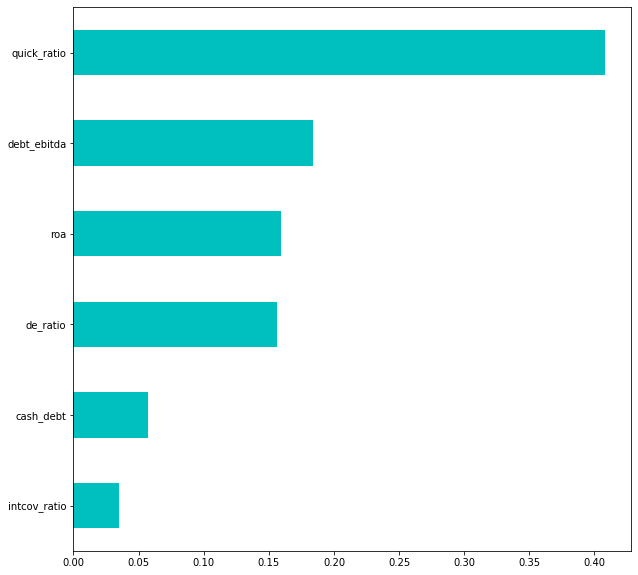

In [48]:
feat_importances = pd.Series(rgr.feature_importances_, index=x_train.columns)
plt.figure(figsize=(10,10)) 
feat_importances.sort_values().plot(kind='barh',color='c')
#feat_importances.sort_values(ascending=False)

## Logistic Regression 

In [49]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5,class_weight='balanced')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(x_train, y_train)

C:\Users\Derrick\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
y_pred=logreg.predict(x_test)

In [51]:
accuracy_score(y_pred, y_test)

0.5636604774535809

In [52]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

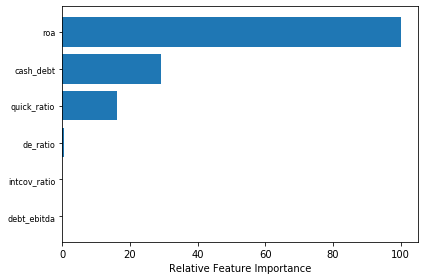

In [53]:
featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

## Confusion Matrix

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[418 328]
 [  1   7]]


## Precision Recall Report 

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72       746
           1       0.02      0.88      0.04         8

    accuracy                           0.56       754
   macro avg       0.51      0.72      0.38       754
weighted avg       0.99      0.56      0.71       754



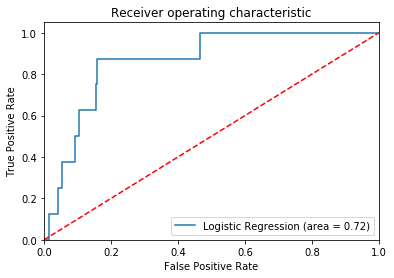

In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [57]:
a = 

SyntaxError: invalid syntax (<ipython-input-57-828ec4a4fd72>, line 1)

In [ ]:
df_bankrupt.drop_duplicates()

In [ ]:
relevant_columns = df_bankrupt[['COMPANY_FKEY','FILE_DATE']]
#list(df_bankrupt.columns)
df['cik'][:5]

# COMPANY_FKEY is CIK
df_bankrupt['COMPANY_FKEY'][:5]

df_bankrupt['COMPANY_FKEY'].nunique()

#filter for 2000-2010
mask = (pd.to_datetime(df_bankrupt['BANK_BEGIN_DATE']).dt.year >1999) &  (pd.to_datetime(df_bankrupt['BANK_BEGIN_DATE']).dt.year < 2011)

df_bankrupt_2000 = df_bankrupt[mask]

df_bankrupt_2000.head()

In [ ]:
df_merge = pd.merge(df, df_bankrupt_2000, left_on = 'cik', right_on = 'COMPANY_FKEY', suffixes = ('_fundam', '_bank'), how = 'left')
df_merge['cik'].nunique()

In [ ]:
# df_merge_11 = df_merge[df_merge['BANKRUPTCY_TYPE']==11]
# df_merge_11

In [ ]:
df_merge.head()

In [ ]:
df_test = df_merge[df_merge['cik'] ==815508]

In [ ]:
df_test.head()

In [ ]:
mask = pd.to_datetime(df_merge['datadate']).dt.year + 1 == pd.to_datetime(df_merge['BANK_BEGIN_DATE']).dt.year

df_merge['bankrupted'] = np.where(mask, 1,0)

In [ ]:
df_merge['bankrupted']

In [ ]:
mask = pd.to_datetime(df_merge['datadate']).dt.year + 1 == pd.to_datetime(df_merge['BANK_BEGIN_DATE']).dt.year
df_merge[mask]

In [ ]:
df_merge['cik'].nunique()

In [ ]:
pd.to_datetime(df_merge['datadate']).dt.year + 1

In [ ]:
np.where()

In [ ]:
pd.to_datetime(df_test['BANK_BEGIN_DATE']).dt.year

In [ ]:
df_test['BANK_BEGIN_DATE']

In [ ]:
df_merge.head()